In [13]:
# Import libraries
from __future__ import print_function
import numpy as np
import zhinst.utils as ziut
import zhinst.core as zic
import allantools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pickle
from itertools import chain

## Connect to the Zurich Instruments lock-in amplifer

In [ ]:
device_id = "devxxxx"
apilevel=6 # 1 for HF2

(daq, device,dprops) = ziut.create_api_session(device_id, apilevel)
print(device)

# Define all the measurement parameters of the Lock-in

In [ ]:
#define initial parameters

amplitude=0.1
rangeamp=1
out_channel = 0
out_mixer_channel = 0
in_channel = 0
demod_index = 0
osc_index = 0
time_constant = 5e-5
filterorder=4
frequency =  1e6
rate=1/(4*2*time_constant)

#set intial conditions for all the channels

ziut.disable_everything(daq, device_id)

exp_setting = [
        ["/%s/sigins/%d/ac" % (device_id, in_channel), 0],
        ["/%s/sigins/%d/diff" % (device_id, in_channel), 0],
        ["/%s/sigins/%d/imp50" % (device_id, in_channel), 0],
        ["/%s/sigins/%d/range" % (device_id, in_channel),1],
        ["/%s/demods/%d/enable" % (device_id, demod_index), 1],        
        ["/%s/demods/%d/adcselect" % (device_id, demod_index), in_channel],
        ["/%s/demods/%d/order" % (device_id, demod_index), filterorder],
        ["/%s/demods/%d/timeconstant" % (device_id, demod_index), time_constant],
        ["/%s/demods/%d/oscselect" % (device_id, demod_index), osc_index],
        ["/%s/demods/%d/harmonic" % (device_id, demod_index), 1],
        ["/%s/sigouts/%d/on" % (device_id, out_channel), 1],
       # ["/%s/sigouts/%d/enables/%d" % (device_id, out_channel, out_mixer_channel), 1],
        ["/%s/sigouts/%d/range" % (device_id, out_channel),rangeamp],
        ["/%s/oscs/%d/freq" % (device_id, osc_index), frequency],
       # ["/%s/sigouts/%d/amplitudes/%d" % (device_id, out_channel, out_mixer_channel),amplitude],
        ["/%s/demods/%d/rate" % (device_id,demod_index),rate],
    ]
daq.set(exp_setting)
daq.setInt('/%s/sigouts/0/on'%device_id, 1)

## Poll the data to start the measurements

In the next section the node is polled and the data is dumped in a temporary file to save memory allocations. For longer measurements its always advised to dump files in a temporary location rather than saving on to a single string.

In [ ]:
time_meas= 3 #Define the total measurement time in [s]

def L1_SimplePoll(device_id,apilevel,demod_index):
    apilevel_example=apilevel
    (daq, device,props) = ziut.create_api_session(device_id, apilevel_example)
    print(device)
    
    # Subscribe to the demodulator's sample node path.
    path = '/%s/demods/%d/sample' % (device, demod_index) # define the path where want to subscribe/measure

    # Poll the subscribed data from the data server. Poll will block and record
    # for poll_length seconds.
    total_length = time_meas # [s] # It will have to looped for the measurement
    poll_length = 1 # [s] # Poll length cannot be more than 5s
    poll_timeout = 500  # [ms]
    poll_flags = 0
    poll_return_flat_dict = True

    numbofPolls = int(np.ceil(total_length/poll_length))
    daq.subscribe(path) #subscribe to the path
    data_i = []
    ij=1
    for i_poll in range(numbofPolls):        
        data_i_poll = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)        
        data_i_poll = data_i_poll[f'{path}']
        file = open("file_%s.dat" % ij,'wb')
        ij=ij+1
        pickle.dump(data_i_poll, file)
        file.close()

    daq.unsubscribe('*') #unsubscribe to all the paths. For a particular path use daq.unsubscribe(path)
    
    # get instrument's clockbase  
    clockbase = float(daq.getInt(f"/{device}/clockbase"))

    #return(data_i,clockbase)
    return(clockbase)

#Function to convert timestamp to real time

def timestamp_to_elapstime(timestamp, clockbase):
    timestamp = timestamp - timestamp[0]
    elapstime = timestamp/clockbase
    return(elapstime)

## Call the SimplePoll function to aquire

In [ ]:
# call the function to poll the data
clockbase=L1_SimplePoll(device_id,apilevel,demod_index)

print('Aquisition Complete')

Trying to connect to dev**** on interface USB
Connected to dev**** via data server 127.**.**.**:80** and interface USB
dev****
Aquisition Complete


# Combine the data into a single file

From the polled data we extract the relevant information. In this case the informations are the quadratures, frequencies and timestamps. End of the sectio the timestamps are converted into real time using the clockbase.

In [ ]:
now = datetime.date.today()  
ij=1

# Prepare the Data structure array to write the data

Data = {'frequency':[],'x':[],'y':[], 'elapsedtime':[]}

for ii in range(time_meas):
    #print(ij)
    file=open("file_%s.dat" % ij,'rb')
    data_i_poll = pickle.load(file)
    Data['elapsedtime'].append(data_i_poll['timestamp'])
    Data['frequency'].append(data_i_poll['frequency'])
    Data['x'].append(data_i_poll['x'])
    Data['y'].append(data_i_poll['y'])
    file.close()
    ij=ij+1

    
Data['elapsedtime']=np.array(list(chain.from_iterable(Data['elapsedtime'])))
Data['x']=np.array(list(chain.from_iterable(Data['x'])))
Data['y']=np.array(list(chain.from_iterable(Data['y'])))
Data['frequency']=np.array(list(chain.from_iterable(Data['frequency'])))

Data['elapsedtime'] = timestamp_to_elapstime(Data['elapsedtime'] , clockbase)
time0=Data['elapsedtime'][1]

# Plot the data

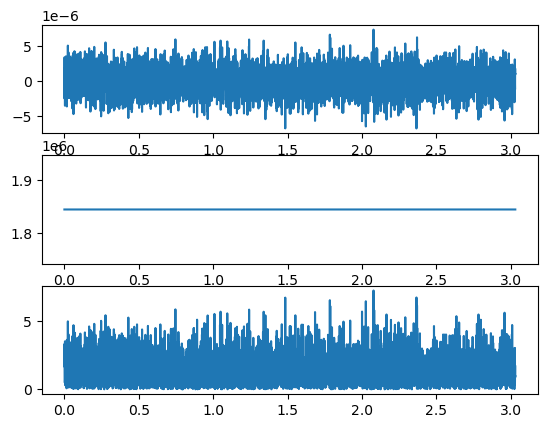

In [ ]:
# using a subplot structure for the plot

plt.subplot(3,1,1)
plt.plot(Data['elapsedtime'],np.arctan(Data['y'],Data['x']))
plt.subplot(3,1,2)
plt.plot(Data['elapsedtime'],Data['frequency'])
plt.subplot(3,1,3)
plt.plot(Data['elapsedtime'],np.sqrt(Data['x']**2+Data['y']**2)*0.7e6)
plt.show()

# Calculate sampling rate 

rate = Data['elapsedtime'][1:-1]-Data['elapsedtime'][0:-2] # not sure whats happening here
rate = np.round(1/rate[0]) #[Hz]   
Data['rate'] = rate

# Compute overlapping Allan Deviation 

In [ ]:
# Calculate Allan variance (ad is squared)

print('started to compute Allan variance')
taus = np.logspace(-1,time_meas,10000)
Data['phase']=np.arctan(Data['y'],Data['x'])

AllanFunction = 'allantools.oadev'   
(t2, ad, ade, adn) = allantools.oadev(Data['phase'],
                                      rate=Data['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data[AllanFunction]={'t2':t2,
                     'av':ad**2 ,
                     'ad':ad,                                   
                     'ade':ade,
                     'adn':adn,
                    }

print('fin')

started to compute Allan variance
fin


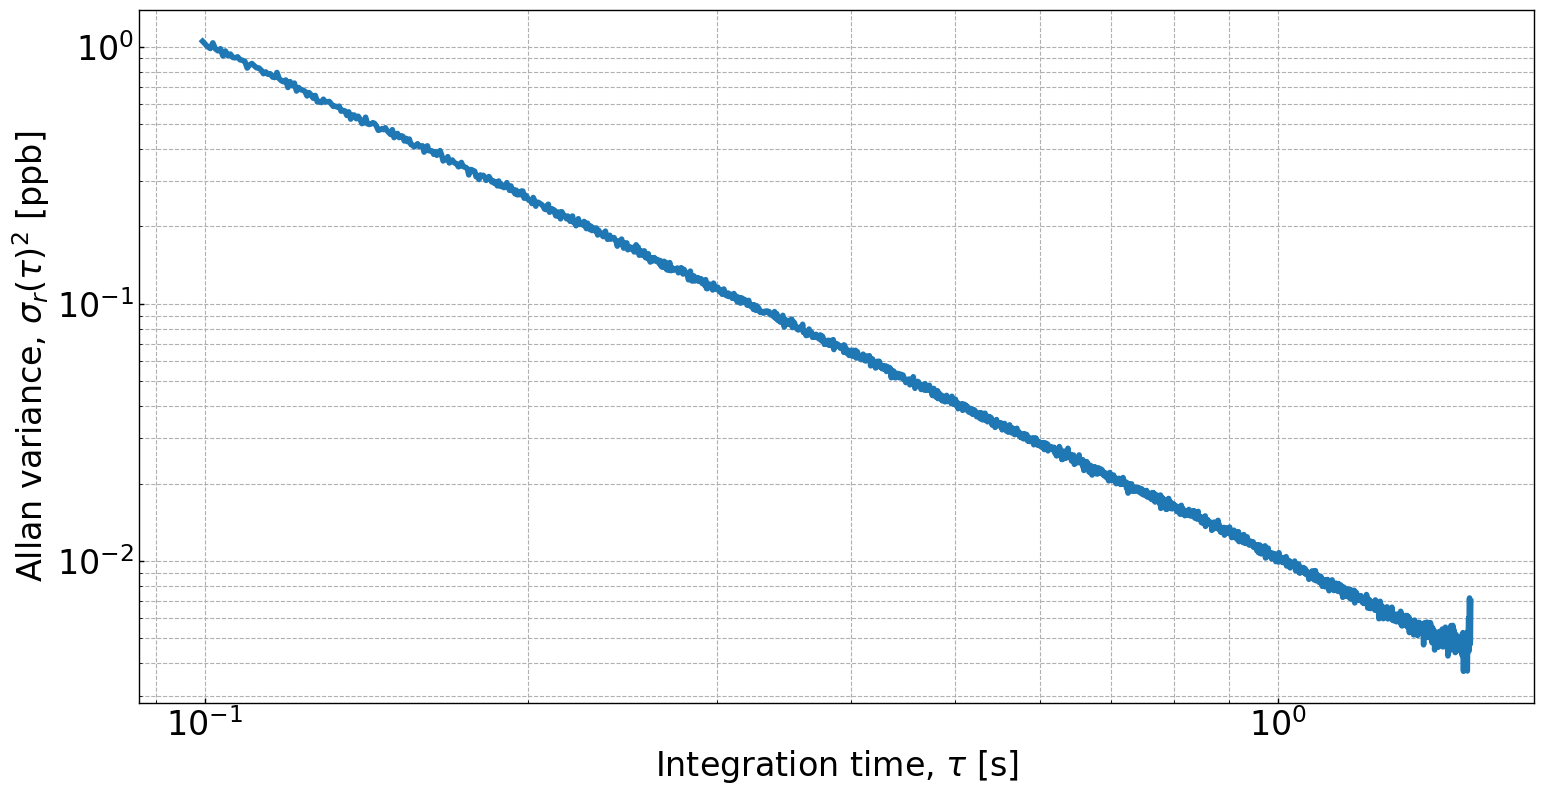

In [ ]:
#%% Plot the results
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24
params = {'font.size': SMALL_SIZE ,
          'axes.linewidth' : 1,
          'axes.titlesize': SMALL_SIZE,
          'axes.labelsize':MEDIUM_SIZE,
          
          "text.usetex": False,

          'legend.fontsize':SMALL_SIZE,
          
          'xtick.major.width' : 1,
          'xtick.labelsize' : SMALL_SIZE,
          'xtick.major.top': True,
          'xtick.minor.top': True,      
          'xtick.direction' :'in',
          
          'ytick.major.width': 1,
          'ytick.labelsize' : SMALL_SIZE,
          'ytick.major.right': True,
          'ytick.minor.right': True,
          'ytick.direction' :'in',
          
          'savefig.format' :'png',
          # 'figure.figsize' :(5,8.27)
          }
mpl.rcParams.update(params)

fig = plt.figure(figsize=[18,9]) 
ax = plt.axes()
ax.plot(Data[AllanFunction]['t2'],
        Data[AllanFunction]['av']*1e9,
        linewidth = 4,
        ) 
    

ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
ax.set_xlabel(r'Integration time, $\tau$ [s]')
ax.set_ylabel(r'Allan variance, $\sigma_r(\tau)^2$ [ppb]')
ax.axes.grid(which='both',
             linestyle = '--' )
ax.axes.tick_params(which='both')
#ax.set_title('Frequency stability, 17 kHz, PLL bandwidth ~ 300 Hz')
          
plt.show()

